In [1]:
import pandas as pd
from utils import drop_skewed_features, drop_correlated_features
from aencoder import Autoencoder
from aencoder import train_autoencoder, get_latent_representation
import torch
import os

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d

In [2]:
def create_grouped_symptom_df(sympdf_path, symp_groups_path, clusters_path, exclude_features=None):
    """
    Creates a DataFrame with symptoms grouped according to specified groups and excludes specified features from grouping,
    adding them as separate columns instead.

    Parameters:
    - sympdf_path (str): Path to CSV file with symptom data.
    - symp_groups_path (str): Path to CSV file with symptom group definitions.
    - clusters_path (str): Path to CSV file with clusters.
    - exclude_features (list of str, optional): Features to exclude from grouping and include as separate columns.

    Returns:
    - DataFrame: Symptoms grouped by specified groups and excluded features as separate columns, indexed by clusters.
    """
    # Load data
    sympdf = pd.read_csv(sympdf_path, index_col=0)
    symp_groups = pd.read_csv(symp_groups_path)
    clusters = pd.read_csv(clusters_path, index_col=0)
    sympdf['cluster'] = clusters['cluster']

    # Initialize the DataFrame with clusters as the index
    grouped_data = pd.DataFrame(index=clusters['cluster'].unique())

    # Exclude specified features from the groups, if any
    if exclude_features is not None:
        for feature in exclude_features:
            if feature in sympdf.columns:
                grouped_data[feature] = sympdf.groupby('cluster')[feature].mean()

    # Group symptoms according to symp_groups, excluding specified features
    for group_name in symp_groups['group'].unique():
        group_symptoms = symp_groups.loc[symp_groups['group'] == group_name, 'symptom']
        relevant_symptoms = sympdf.columns.intersection(group_symptoms).difference(exclude_features or [])
        if not relevant_symptoms.empty:
            # Compute the mean for each cluster for the current group
            grouped_avg = sympdf.groupby('cluster')[relevant_symptoms].mean().mean(axis=1)
            grouped_data[group_name] = grouped_avg

    # Ensure the index is sorted to maintain the cluster order
    grouped_data.sort_index(inplace=True)
    
    return grouped_data

sympdf_path = "/Users/leo/Programming/PLR/Leo/data/cleaned_data_SYMPTOMS_9_13_23.csv"
symp_groups_path = "/Users/leo/Programming/PLR/clusterings/tessa/symptom_groups.csv"
clusters_path = "/Users/leo/Programming/PLR/clusterings/leo/final_aencoder_hdbscan_6.csv"

grouped_df = create_grouped_symptom_df(sympdf_path, symp_groups_path, clusters_path)

exclude_features = ["Physical_PEM_Severity", "Cognitive_PEM_Severity"]

grouped_df_pem = create_grouped_symptom_df(sympdf_path, symp_groups_path, clusters_path, exclude_features)

In [3]:
df = pd.read_csv('/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl2/cl2_full_dataset.csv')

opt_params = {'silhouette_score': 0.5902, 'num_clusters': 9, 'skew_threshold': 0.8, 'corr_threshold': 0.5, 'hidden_size': 64, 'latent_dim': 2, 'learning_rate': 0.01, 'epochs': 500, 'hdbscan_params': {'min_cluster_size': 5, 'min_samples': 25}, 'dataset': 5}

In [4]:
def calculate_cluster_sizes(df):
    """
    Calculate the sizes of each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'cluster' column.

    Returns:
    Series: A pandas Series with cluster labels as index and their respective sizes as values.
    """
    cluster_sizes = df.groupby('cluster').size()
    return cluster_sizes

In [5]:
calculate_cluster_sizes(df)

cluster
-1     222
 0    1125
 1    2126
 2     321
 3     498
 4     850
 5     889
dtype: int64

In [6]:
def average_symptom_count_by_cluster(df):
    """
    Calculate the average symptom count for each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with columns for symptoms starting with "Symptom_" and a 'cluster' column.

    Returns:
    DataFrame: A pandas DataFrame with the average symptom count for each cluster.
    """
    # Filter columns that start with 'Symptom_'
    symptom_columns = [col for col in df.columns if col.startswith('Symptom_')]

    # Sum the symptom columns for each row
    df['total_symptoms'] = df[symptom_columns].sum(axis=1)

    # Calculate the average symptom count for each cluster
    average_symptoms = round(df.groupby('cluster')['total_symptoms'].mean(),0)

    return average_symptoms

# Example usage
# Assuming you have your DataFrame loaded as 'df'
average_symptoms = average_symptom_count_by_cluster(df)
print(average_symptoms)


cluster
-1    16.0
 0    44.0
 1    60.0
 2    35.0
 3    46.0
 4    28.0
 5    37.0
Name: total_symptoms, dtype: float64


In [7]:
df["Demographics_Gender_Cleaned"].value_counts()

Demographics_Gender_Cleaned
Woman                                           4703
Man                                             1205
Non-binary/Genderqueer/Gender non-conforming     100
Name: count, dtype: int64

In [8]:
df["Demographics_Age_Cleaned"].value_counts()

Demographics_Age_Cleaned
40-49    1725
50-59    1460
30-39    1352
60-69     736
18-29     526
70-79     213
80+        19
Name: count, dtype: int64

In [9]:
def average_women_to_other_ratio_by_cluster(df):
    """
    Calculate the average ratio of 'Women' to 'Other' for each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'Demographics_Gender_Cleaned' and a 'cluster' column.

    Returns:
    Series: A pandas Series with cluster labels as index and the average ratio of 'Women' to 'Other' as values.
    """
    # Create a new column for 'Woman' (1) and 'Other' (0)
    df['woman_or_other'] = df['Demographics_Gender_Cleaned'].apply(lambda x: 1 if x == 'Woman' else 0)

    # Calculate the average ratio for each cluster
    average_ratios = round(df.groupby('cluster')['woman_or_other'].mean(),3)

    return average_ratios

average_women_to_other_ratio_by_cluster(df)

cluster
-1    0.667
 0    0.795
 1    0.830
 2    0.791
 3    0.791
 4    0.714
 5    0.721
Name: woman_or_other, dtype: float64

In [10]:
def convert_age(age_string):
    conversion_dict = {
        '30-39': 35,
        '40-49': 45,
        '50-59': 55,
        '18-29': 24,
        '60-69': 65,
        '70-79': 75,
        '80+': 85
    }
    return conversion_dict[age_string]

def average_age_by_cluster(df):
    """
    Calculate the average age for each cluster in the DataFrame, rounded to one decimal place.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'Demographics_Age_Cleaned' and a 'cluster' column.

    Returns:
    DataFrame: A pandas DataFrame with cluster labels as index and the average age as values, rounded to one decimal place.
    """
    # Convert age ranges to average ages
    df['average_age'] = df['Demographics_Age_Cleaned'].apply(convert_age)

    # Calculate the average age for each cluster
    average_ages = df.groupby('cluster')['average_age'].mean().round(1)

    return average_ages

In [11]:
average_age_by_cluster(df)

cluster
-1    47.6
 0    47.3
 1    46.7
 2    45.9
 3    46.3
 4    47.7
 5    47.1
Name: average_age, dtype: float64

In [12]:
df["Cognitive_PEM_Severity"].value_counts()

Cognitive_PEM_Severity
8.0     772
7.0     724
0.0     610
5.0     603
6.0     565
10.0    520
9.0     479
4.0     346
3.0     298
2.0     216
1.0     196
Name: count, dtype: int64

In [13]:
def average_normalized_pem_severity_by_cluster(df):
    """
    Calculate the average normalized PEM severity for each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'Physical_PEM_Severity' column and a 'cluster' column.

    Returns:
    Series: A pandas Series with cluster labels as index and the average normalized PEM severity as values.
    """
    # Normalize the 'Physical_PEM_Severity' column
    df['normalized_pem_severity'] = df['Physical_PEM_Severity'] / 10

    # Calculate the average normalized PEM severity for each cluster
    average_severity = round(df.groupby('cluster')['normalized_pem_severity'].mean(),3)

    return average_severity

average_normalized_pem_severity_by_cluster(df)

cluster
-1    0.619
 0    0.773
 1    0.811
 2    0.747
 3    0.773
 4    0.719
 5    0.735
Name: normalized_pem_severity, dtype: float64

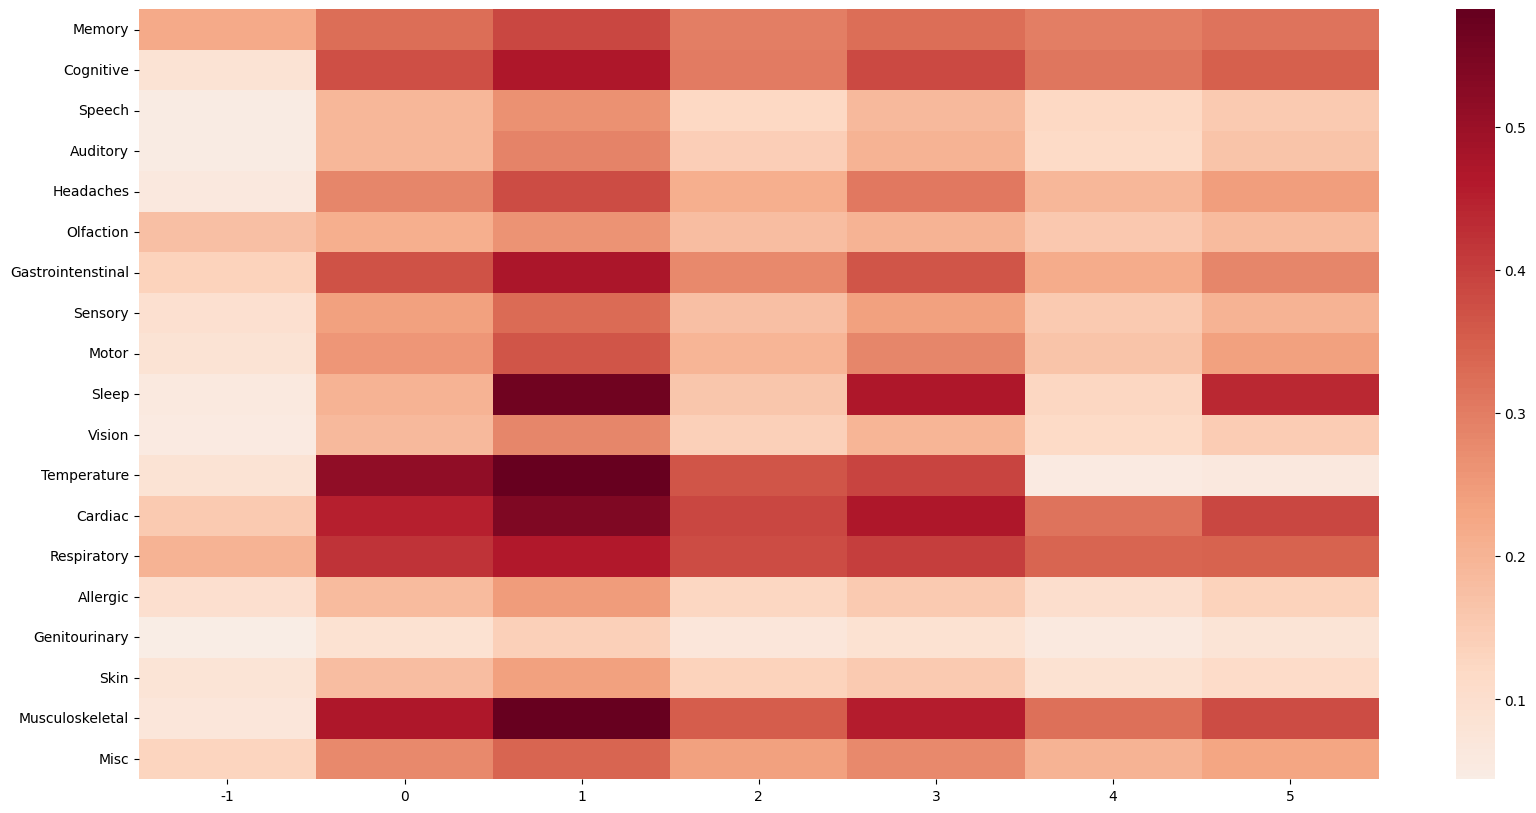

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_grouped_symp_freq(grouped_data, mode="mean", saveloc=None):
    """
    Plot grouped symptom frequencies by cluster.

    Parameters:
    grouped_data (DataFrame): DataFrame with symptoms already grouped by cluster.
    mode (str): Aggregation mode, 'mean' by default. [Note: This parameter is kept for potential future use]
    saveloc (str, optional): Location to save the plot. Default is None.

    Returns:
    None: Directly plots the heatmap of average scores by symptom group.
    """
    # Check if 'mode' is implemented, for now, it's not used but can be expanded for different aggregations
    if mode != "mean":
        raise ValueError("Currently, only 'mean' mode is supported.")

    # Use the provided grouped_data for plotting
    plt.figure(figsize=(20, 10))
    sns.heatmap(grouped_data.transpose(), cmap='RdBu_r', center=0, annot=False)

    if saveloc is not None:
        plt.savefig(saveloc)

    plt.show()

    
avg_df_grouped = plot_grouped_symp_freq(grouped_df)

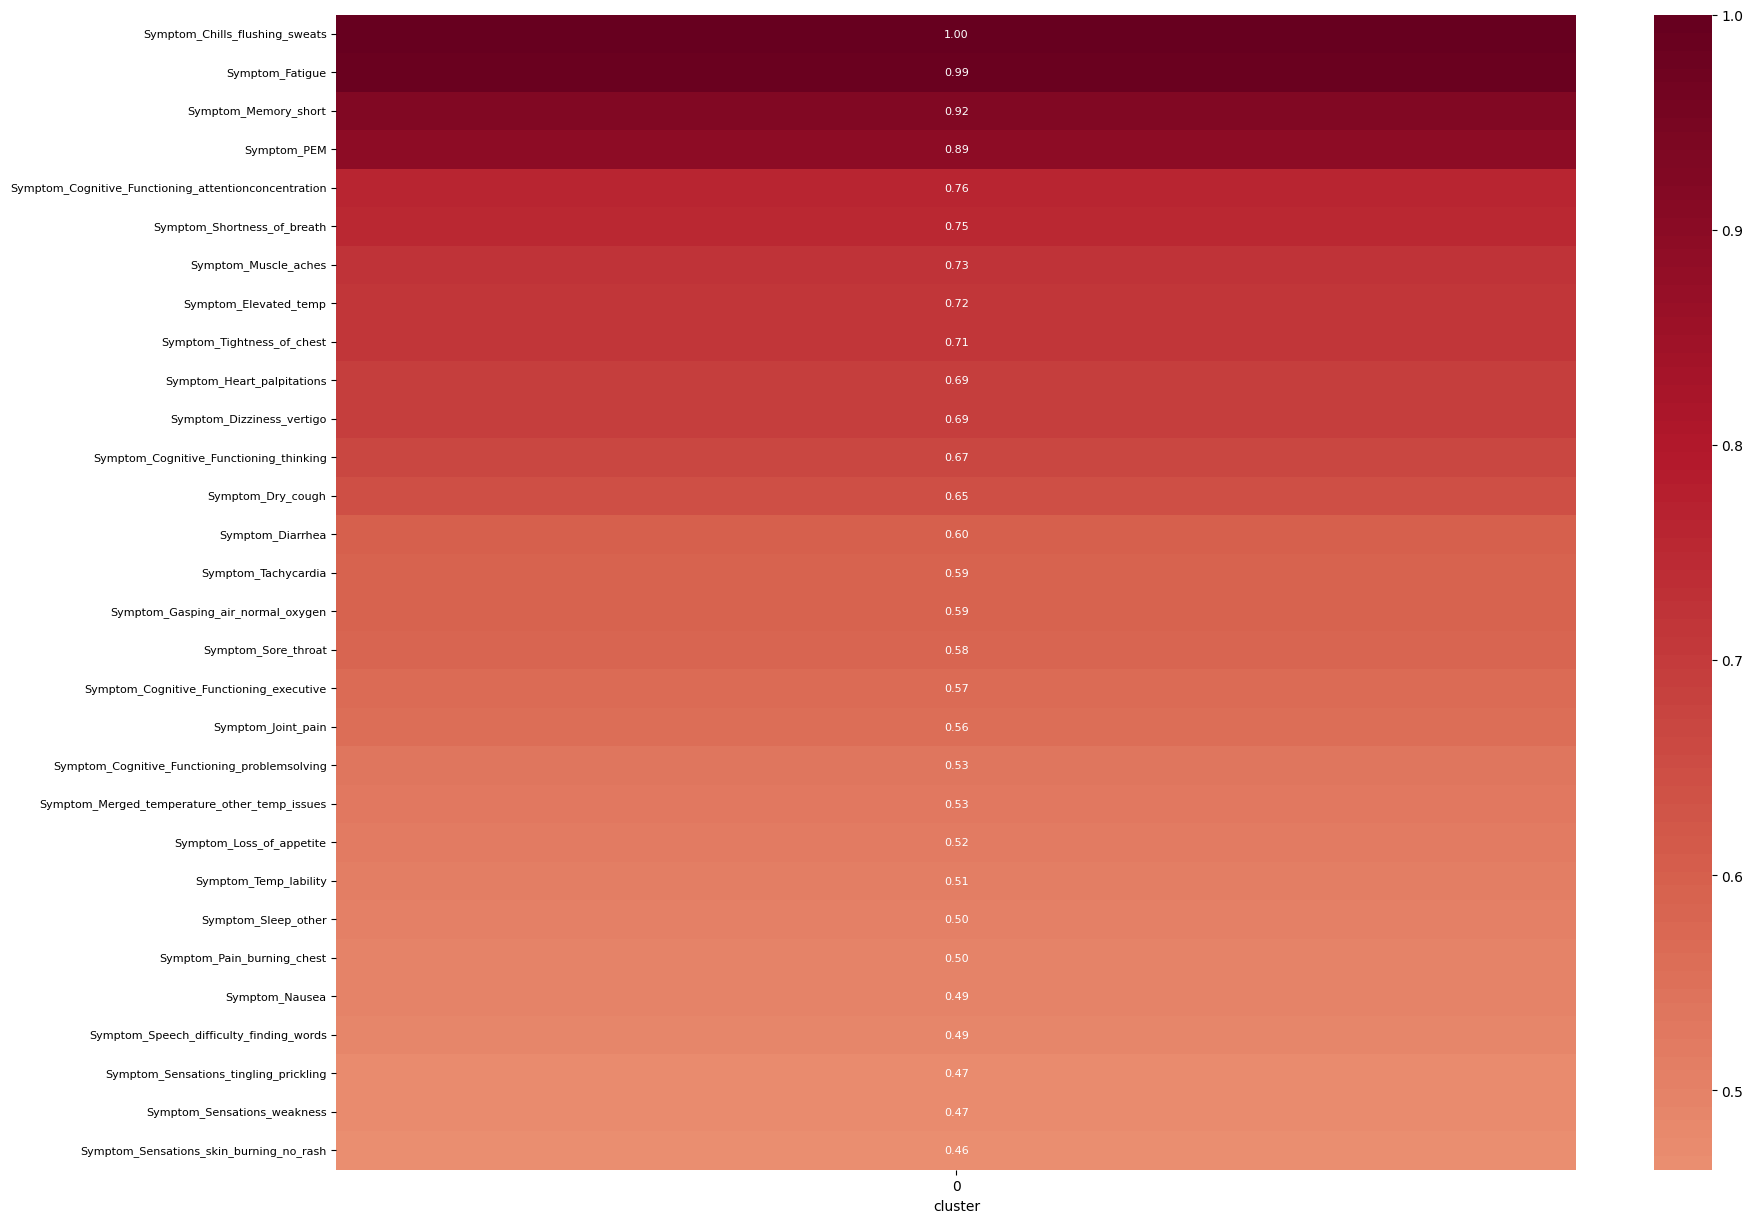

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_symp_avg_per_cluster(clusters, sympdf=None, include_misc=True, saveloc=None, selected_clusters=None, top_n_features=None):
    """
    Plot average symptom values by cluster, with options to filter by specific clusters
    and to limit the display to top n highest features, including value annotations.

    Parameters:
    clusters (str or DataFrame): Path to CSV file with clusters or DataFrame with clusters.
    sympdf (DataFrame, optional): DataFrame with symptoms. Default is None.
    include_misc (bool): Whether to include 'Misc' symptoms. Default is True.
    saveloc (str, optional): Location to save the plot. Default is None.
    selected_clusters (list of int/str, optional): Specific clusters to display. Default is None.
    top_n_features (int, optional): Number of top features to display. Default is None.

    Returns:
    DataFrame: Average scores by symptom.
    """
    # Read clusters from CSV if it's a string
    if isinstance(clusters, str):
        clusters = pd.read_csv(clusters, index_col=0)

    if sympdf is None:
        # Placeholder for actual symptoms data path
        df = pd.read_csv("/Users/leo/Programming/PLR/Leo/data/cleaned_data_SYMPTOMS_9_13_23.csv", index_col=0)  # Update with the correct path
        sympdf = df.loc[:, df.columns.str.startswith('Symptom_')]

    if not include_misc:
        sympdf = sympdf.drop(columns=[col for col in sympdf.columns if 'Misc' in col], errors='ignore')

    sympdf['cluster'] = clusters['cluster']

    if selected_clusters is not None:
        sympdf = sympdf[sympdf['cluster'].isin(selected_clusters)]

    # Compute the mean for each symptom per cluster
    avg_scores_by_symptom = sympdf.groupby('cluster').mean()

    if top_n_features is not None:
        transposed_avg_scores = avg_scores_by_symptom.transpose()
        
        mean_scores = transposed_avg_scores.mean(axis=1) if selected_clusters is None else transposed_avg_scores[selected_clusters].mean(axis=1)
        top_features = mean_scores.nlargest(top_n_features).index
        transposed_avg_scores = transposed_avg_scores.loc[top_features]
    else:
        transposed_avg_scores = avg_scores_by_symptom.transpose()

    fig_height = max(10, len(transposed_avg_scores) * 0.5)
    plt.figure(figsize=(20, fig_height))

    ax = sns.heatmap(transposed_avg_scores, cmap='RdBu_r', center=0, annot=True, fmt=".2f", annot_kws={"size": 8})
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size=8)

    if saveloc is not None:
        plt.savefig(saveloc)

    plt.show()

    return avg_scores_by_symptom

# Note: Replace "path_to_symptoms_data.csv" and the clusters path with actual paths.


# Example usage
plot_avg_per_cluster= plot_symp_avg_per_cluster(
    clusters="/Users/leo/Programming/PLR/clusterings/leo/final_aencoder_hdbscan_6.csv",
    selected_clusters=[0],
    include_misc=False,
    top_n_features=30
)


In [16]:
def compute_symptom_group_difference(df):
    """
    Compute the difference in average symptom group scores for each cluster from the overall average.

    Parameters:
    df (DataFrame): DataFrame containing symptom group scores with clusters as rows and symptom groups as columns.

    Returns:
    DataFrame: A DataFrame showing the difference in average symptom group scores for each cluster.
    """

    # Calculate the overall average for each symptom group
    overall_avg = df.mean()

    # Calculate the difference for each cluster
    difference_df = df.subtract(overall_avg, axis='columns')

    return difference_df

# Assuming your DataFrame is named df
# df = your_dataframe_with_clusters_and_symptoms
enriched_df = compute_symptom_group_difference(grouped_df)

In [17]:
enriched_df

,Memory,Cognitive,Speech,Auditory,Headaches,Olfaction,Gastrointenstinal,Sensory,Motor,Sleep,Vision,Temperature,Cardiac,Respiratory,Allergic,Genitourinary,Skin,Musculoskeletal,Misc
-1,-0.088953,-0.242303,-0.108142,-0.116082,-0.177627,-0.021108,-0.168638,-0.110291,-0.143528,-0.230829,-0.109369,-0.211547,-0.234836,-0.161525,-0.052995,-0.037314,-0.062577,-0.304602,-0.113839
0,0.016181,0.049315,0.035324,0.026954,0.043862,0.016772,0.066308,0.033534,0.027583,-0.086010,0.029046,0.222023,0.064645,0.054543,0.036772,0.008319,0.038372,0.094674,0.034807
1,0.076256,0.147681,0.111309,0.119746,0.137567,0.066151,0.172373,0.124946,0.138496,0.274676,0.123182,0.288148,0.156750,0.103519,0.097530,0.055653,0.099304,0.205002,0.094507
2,-0.014001,-0.023351,-0.034291,-0.021099,-0.027812,-0.016877,-0.022898,-0.027315,-0.030600,-0.127083,-0.021879,0.072289,0.001697,0.014882,-0.024443,-0.011365,-0.005892,-0.022745,-0.004665
3,0.016735,0.060454,0.031437,0.038687,0.067087,0.008538,0.060851,0.034070,0.055769,0.180693,0.036747,0.099569,0.083193,0.037318,0.004303,0.009104,0.011707,0.080777,0.037811
4,-0.011280,-0.012168,-0.033036,-0.047178,-0.045809,-0.040607,-0.087063,-0.051160,-0.061861,-0.162329,-0.046350,-0.241548,-0.071088,-0.027732,-0.046432,-0.021341,-0.051994,-0.054666,-0.038301
5,0.005061,0.020372,-0.002600,-0.001028,0.002731,-0.012869,-0.020933,-0.003785,0.014140,0.150882,-0.011378,-0.228934,-0.000361,-0.021005,-0.014734,-0.003056,-0.028920,0.001561,-0.010319


In [18]:
grouped_df

,Memory,Cognitive,Speech,Auditory,Headaches,Olfaction,Gastrointenstinal,Sensory,Motor,Sleep,Vision,Temperature,Cardiac,Respiratory,Allergic,Genitourinary,Skin,Musculoskeletal,Misc
-1,0.221622,0.081982,0.048423,0.050050,0.061712,0.175676,0.134635,0.094595,0.083333,0.058559,0.052177,0.082207,0.152252,0.203266,0.097097,0.044144,0.078829,0.070946,0.128734
0,0.326756,0.373600,0.191889,0.193086,0.283200,0.213556,0.369580,0.238420,0.254444,0.203378,0.190593,0.515778,0.451733,0.419333,0.186864,0.089778,0.179778,0.470222,0.277380
1,0.386830,0.471966,0.267874,0.285879,0.376905,0.262935,0.475645,0.329832,0.365357,0.564064,0.284729,0.581903,0.543838,0.468309,0.247622,0.137112,0.240710,0.580550,0.337080
2,0.296573,0.300935,0.122274,0.145033,0.211526,0.179907,0.280374,0.177570,0.196262,0.162305,0.139668,0.366044,0.388785,0.379673,0.125649,0.070093,0.135514,0.352804,0.237908
3,0.327309,0.384739,0.188002,0.204819,0.306426,0.205321,0.364123,0.238956,0.282631,0.470080,0.198293,0.393323,0.470281,0.402108,0.154395,0.090562,0.153112,0.456325,0.280385
4,0.299294,0.312118,0.123529,0.118954,0.193529,0.156176,0.216209,0.153725,0.165000,0.127059,0.115196,0.052206,0.316000,0.337059,0.103660,0.060118,0.089412,0.320882,0.204272
5,0.315636,0.344657,0.153965,0.165104,0.242070,0.183915,0.282340,0.201100,0.241001,0.440270,0.150169,0.064820,0.386727,0.343785,0.135358,0.078403,0.112486,0.377109,0.232254


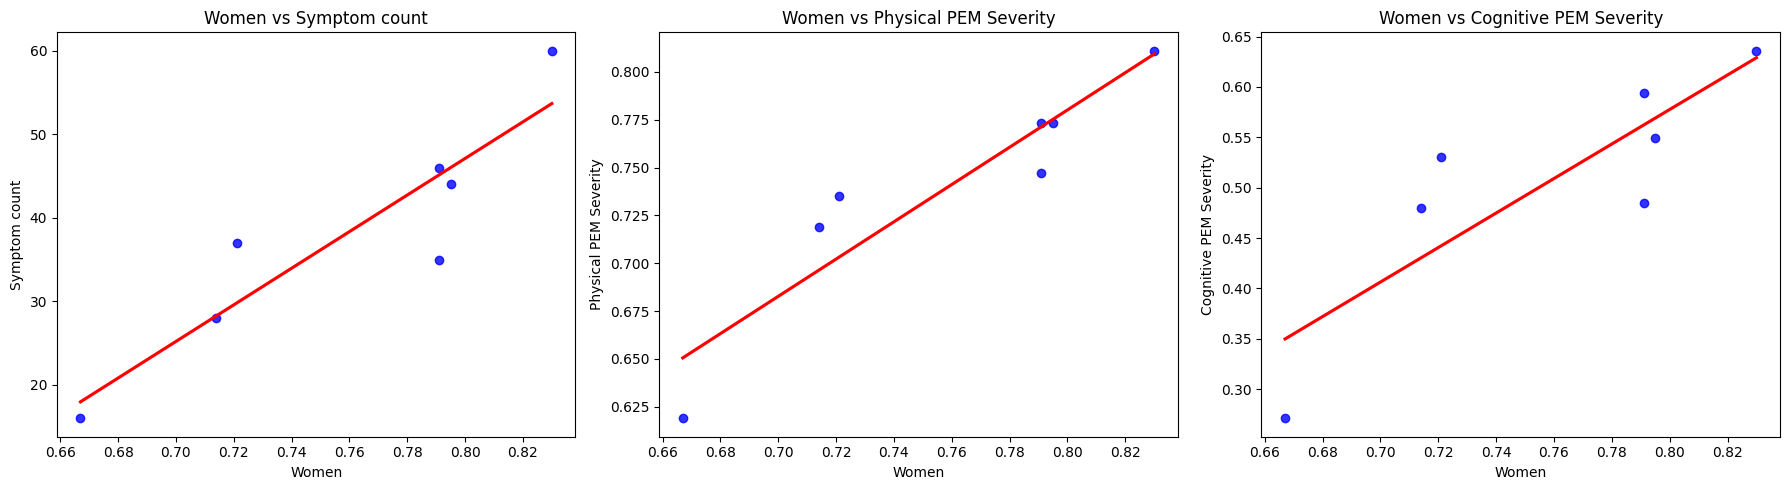

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Sample data in a dictionary format
data = {
    'Cluster Name': ['AX', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5'],
    'Size': [222, 1125, 2126, 321, 498, 850, 889],
    'Symptom count': [16, 44, 60, 35, 46, 28, 37],
    'Women': [0.667, 0.795, 0.830, 0.791, 0.791, 0.714, 0.721],
    'Physical PEM Severity': [0.619, 0.773, 0.811, 0.747, 0.773, 0.719, 0.735],
    'Cognitive PEM Severity': [0.271, 0.549, 0.636, 0.485, 0.594, 0.480, 0.530]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plots with trend lines
sns.regplot(ax=axes[0], x='Women', y='Symptom count', data=df, scatter=True, ci=None, color='blue', line_kws={'color': 'red'})
axes[0].set_title('Women vs Symptom count')

sns.regplot(ax=axes[1], x='Women', y='Physical PEM Severity', data=df, scatter=True, ci=None, color='blue', line_kws={'color': 'red'})
axes[1].set_title('Women vs Physical PEM Severity')

sns.regplot(ax=axes[2], x='Women', y='Cognitive PEM Severity', data=df, scatter=True, ci=None, color='blue', line_kws={'color': 'red'})
axes[2].set_title('Women vs Cognitive PEM Severity')

plt.tight_layout()
plt.show()


In [20]:
import pandas as pd

# Define the data
data = {
    'Comparison': ['Women vs Symptom count', 'Women vs Physical PEM Severity', 'Women vs Cognitive PEM Severity'],
    'Correlation': [0.8829187134416479, 0.9727272727272728, 0.8829187134416479],
    'P-value': [0.008450342381896611, 0.00023248789660928963, 0.008450342381896611]
}

# Create a DataFrame
correlation_table = pd.DataFrame(data)

# Display the table
print(correlation_table)


                        Comparison  Correlation   P-value
0           Women vs Symptom count     0.882919  0.008450
1   Women vs Physical PEM Severity     0.972727  0.000232
2  Women vs Cognitive PEM Severity     0.882919  0.008450


In [21]:
# Assuming 'df' is your DataFrame
# Let's say the average temperature-related symptom severity for Cluster A4 is 0.052
cluster_a4_temp_avg = 0.052

# Calculate the mean and standard deviation for temperature-related symptoms across all clusters
temperature_mean = grouped_df['Temperature'].mean()
temperature_std = grouped_df['Temperature'].std()

# Calculate the Z-score for Cluster A4's average temperature-related symptom severity
z_score = (cluster_a4_temp_avg - temperature_mean) / temperature_std

print(f"Mean Temperature Severity Across Clusters: {temperature_mean}")
print(f"Standard Deviation of Temperature Severity Across Clusters: {temperature_std}")
print(f"Z-score for Cluster A4's Temperature Severity: {z_score}")


Mean Temperature Severity Across Clusters: 0.2937543472527903
Standard Deviation of Temperature Severity Across Clusters: 0.2247117896080944
Z-score for Cluster A4's Temperature Severity: -1.075841849127804


In [22]:
df_filtered = grouped_df.loc[grouped_df.index != -1]

# The average Sleep-related symptom severity for Cluster A4 remains the same
cluster_a5_temp_avg = 0.23

# Calculate the mean and standard deviation for Sleep-related symptoms across non-outlier clusters
Sleep_mean_filtered = df_filtered['Sleep'].mean()
Sleep_std_filtered = df_filtered['Sleep'].std()

# Calculate the Z-score for Cluster A4's average Sleep-related symptom severity, excluding outliers
z_score_filtered = (cluster_a4_temp_avg - Sleep_mean_filtered) / Sleep_std_filtered

print(f"Mean Sleep Severity Across Non-Outlier Clusters: {Sleep_mean_filtered}")
print(f"Standard Deviation of Sleep Severity Across Non-Outlier Clusters: {Sleep_std_filtered}")
print(f"Z-score for Cluster A4's Sleep Severity (excluding outliers): {z_score_filtered}")

Mean Sleep Severity Across Non-Outlier Clusters: 0.3278593591155372
Standard Deviation of Sleep Severity Across Non-Outlier Clusters: 0.18540778400408167
Z-score for Cluster A4's Sleep Severity (excluding outliers): -1.4878520909859119


In [23]:
from scipy.spatial.distance import euclidean
import pandas as pd
import numpy as np

# Assuming 'grouped_df' is your DataFrame

# Initialize the dictionary to store results
cluster_similarities = {}

# Calculate distances and similarities
for i in grouped_df.index:
    distances = []
    for j in grouped_df.index:
        if i != j:
            dist = euclidean(grouped_df.loc[i], grouped_df.loc[j])
            print(f"Distance between Cluster {i} and Cluster {j}: {dist:.4f}")
            print(f"We are locing at {grouped_df.loc[i]} and {grouped_df.loc[j]}")
            distances.append((j, dist))
    
    # Sort clusters by distance (similarity)
    distances.sort(key=lambda x: x[1])
    
    # Store sorted clusters and distances in the result dictionary
    # Including the distance to the most similar cluster
    cluster_similarities[i] = {
        'similar_clusters': [x[0] for x in distances],
        'distance_to_most_similar': distances[0][1]  # Euclidean distance to the most similar cluster
    }

    # For the most similar cluster, find the top 3 biggest differences
    most_similar_cluster = distances[0][0]
    diff = (grouped_df.loc[i] - grouped_df.loc[most_similar_cluster]).abs()
    top_diffs = diff.nlargest(3).to_dict()
    cluster_similarities[i]['top_differences'] = top_diffs

# Initialize an empty list to store each row of the summary table
summary_data = []

# Iterate through each cluster in the cluster_similarities dictionary
for cluster, info in cluster_similarities.items():
    # Extract the most similar cluster and the distance
    most_similar_cluster = info['similar_clusters'][0]
    distance_to_most_similar = info['distance_to_most_similar']
    
    # Prepare the differences data
    differences = info['top_differences']
    differences_str = '; '.join([f"{feature}: {diff:.4f}" for feature, diff in differences.items()])
    
    # Append a new row to the summary data list
    summary_data.append({
        'Cluster': cluster,
        'Most Similar Cluster': most_similar_cluster,
        'Distance to Most Similar': distance_to_most_similar,
        'Top Differences': differences_str
    })

# Convert the summary data into a pandas DataFrame
summary_df = pd.DataFrame(summary_data)

# Optionally, set the 'Cluster' column as the index
summary_df.set_index('Cluster', inplace=True)

# Display the DataFrame
summary_df


Distance between Cluster -1 and Cluster 0: 0.9269
We are locing at Memory               0.221622
Cognitive            0.081982
Speech               0.048423
Auditory             0.050050
Headaches            0.061712
Olfaction            0.175676
Gastrointenstinal    0.134635
Sensory              0.094595
Motor                0.083333
Sleep                0.058559
Vision               0.052177
Temperature          0.082207
Cardiac              0.152252
Respiratory          0.203266
Allergic             0.097097
Genitourinary        0.044144
Skin                 0.078829
Musculoskeletal      0.070946
Misc                 0.128734
Name: -1, dtype: float64 and Memory               0.326756
Cognitive            0.373600
Speech               0.191889
Auditory             0.193086
Headaches            0.283200
Olfaction            0.213556
Gastrointenstinal    0.369580
Sensory              0.238420
Motor                0.254444
Sleep                0.203378
Vision               0.190593
Temp

,Most Similar Cluster,Distance to Most Similar,Top Differences
Cluster,,,
-1,4,0.476259,Musculoskeletal: 0.2499; Cognitive: 0.2301; Ca...
0,2,0.297215,Temperature: 0.1497; Musculoskeletal: 0.1174; ...
1,3,0.398453,Temperature: 0.1886; Musculoskeletal: 0.1242; ...
2,0,0.297215,Temperature: 0.1497; Musculoskeletal: 0.1174; ...
3,0,0.300836,Sleep: 0.2667; Temperature: 0.1225; Allergic: ...
4,2,0.345936,Temperature: 0.3138; Cardiac: 0.0728; Gastroin...
5,4,0.360899,Sleep: 0.3132; Motor: 0.0760; Cardiac: 0.0707


In [24]:
# Access the "Top Differences" column from the summary DataFrame
top_differences = summary_df['Top Differences']

# Display the "Top Differences" for all clusters
print(top_differences)

# Access the "Top Differences" for a specific cluster, e.g., cluster 0
cluster_id = 5  # or any other cluster identifier from your data
if cluster_id in top_differences.index:
    print(f"Top Differences for Cluster {cluster_id}:")
    print(top_differences[cluster_id])
else:
    print(f"Cluster {cluster_id} not found in the summary.")


Cluster
-1    Musculoskeletal: 0.2499; Cognitive: 0.2301; Ca...
 0    Temperature: 0.1497; Musculoskeletal: 0.1174; ...
 1    Temperature: 0.1886; Musculoskeletal: 0.1242; ...
 2    Temperature: 0.1497; Musculoskeletal: 0.1174; ...
 3    Sleep: 0.2667; Temperature: 0.1225; Allergic: ...
 4    Temperature: 0.3138; Cardiac: 0.0728; Gastroin...
 5        Sleep: 0.3132; Motor: 0.0760; Cardiac: 0.0707
Name: Top Differences, dtype: object
Top Differences for Cluster 5:
Sleep: 0.3132; Motor: 0.0760; Cardiac: 0.0707


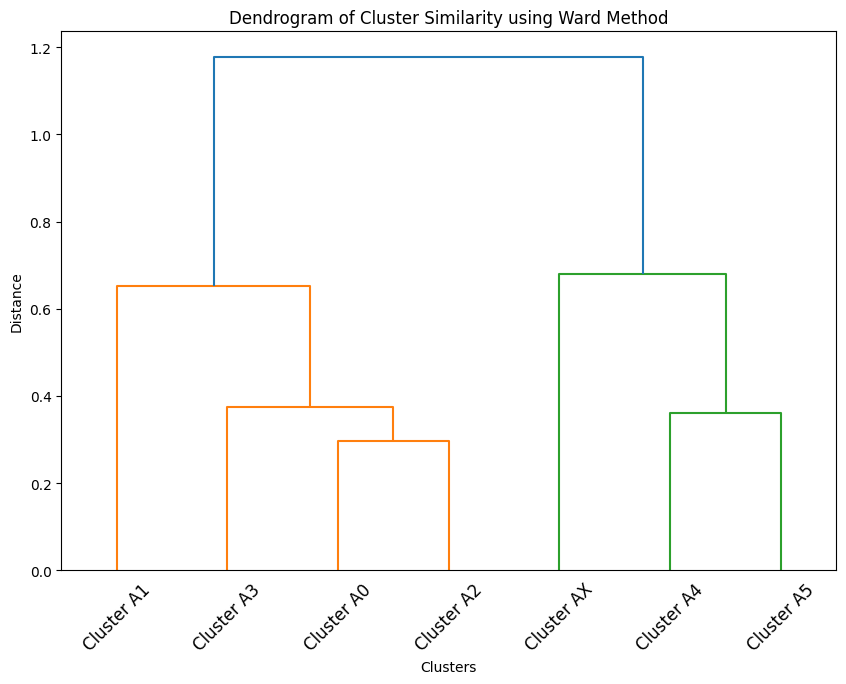

In [25]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd

# Hierarchical Clustering for Similarity Analysis
linked = linkage(grouped_df, method='ward')

# Custom labels for dendrogram
custom_labels = ["Cluster AX" if i == -1 else f"Cluster A{i}" for i in grouped_df.index]

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=custom_labels, orientation='top')
plt.title('Dendrogram of Cluster Similarity using Ward Method')
plt.xticks(rotation=45)  # Rotate labels for better readability if necessary
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.show()


In [26]:
import pandas as pd

# Assuming 'grouped_df' is your DataFrame containing the average values for each symptom group for each cluster

# Calculate the mean and standard deviation for 'Temperature' and 'Sleep' across all clusters
temperature_mean = grouped_df['Temperature'].mean()
temperature_std = grouped_df['Temperature'].std()

sleep_mean = grouped_df['Sleep'].mean()
sleep_std = grouped_df['Sleep'].std()

# Assuming cluster A1's data is in a row labeled 'A1' or identified by a specific index
# Extract the values for 'Temperature' and 'Sleep' for cluster A1
# Here, replace 'A1' with the appropriate label or index for A1's data
a1_temperature = grouped_df.loc[1, 'Temperature']
a1_sleep = grouped_df.loc[1, 'Sleep']

# Compute the Z-scores
z_score_temperature = (a1_temperature - temperature_mean) / temperature_std
z_score_sleep = (a1_sleep - sleep_mean) / sleep_std
z_score_enriched_temperature = (a1_temperature - temperature_mean)
z_score_enriched_sleep = (a1_sleep - sleep_mean)

print(f"Z-score for Temperature in A1: {z_score_temperature}")
print(f"Z-score for Sleep in A1: {z_score_sleep}")
print(f"Z-score for Enriched Temperature in A1: {z_score_enriched_temperature}")
print(f"Z-score for Enriched Sleep in A1: {z_score_enriched_sleep}")

Z-score for Temperature in A1: 1.28230159754552
Z-score for Sleep in A1: 1.3907497789484575
Z-score for Enriched Temperature in A1: 0.28814828680177224
Z-score for Enriched Sleep in A1: 0.2746761537176933


In [27]:
grouped_df

,Memory,Cognitive,Speech,Auditory,Headaches,Olfaction,Gastrointenstinal,Sensory,Motor,Sleep,Vision,Temperature,Cardiac,Respiratory,Allergic,Genitourinary,Skin,Musculoskeletal,Misc
-1,0.221622,0.081982,0.048423,0.050050,0.061712,0.175676,0.134635,0.094595,0.083333,0.058559,0.052177,0.082207,0.152252,0.203266,0.097097,0.044144,0.078829,0.070946,0.128734
0,0.326756,0.373600,0.191889,0.193086,0.283200,0.213556,0.369580,0.238420,0.254444,0.203378,0.190593,0.515778,0.451733,0.419333,0.186864,0.089778,0.179778,0.470222,0.277380
1,0.386830,0.471966,0.267874,0.285879,0.376905,0.262935,0.475645,0.329832,0.365357,0.564064,0.284729,0.581903,0.543838,0.468309,0.247622,0.137112,0.240710,0.580550,0.337080
2,0.296573,0.300935,0.122274,0.145033,0.211526,0.179907,0.280374,0.177570,0.196262,0.162305,0.139668,0.366044,0.388785,0.379673,0.125649,0.070093,0.135514,0.352804,0.237908
3,0.327309,0.384739,0.188002,0.204819,0.306426,0.205321,0.364123,0.238956,0.282631,0.470080,0.198293,0.393323,0.470281,0.402108,0.154395,0.090562,0.153112,0.456325,0.280385
4,0.299294,0.312118,0.123529,0.118954,0.193529,0.156176,0.216209,0.153725,0.165000,0.127059,0.115196,0.052206,0.316000,0.337059,0.103660,0.060118,0.089412,0.320882,0.204272
5,0.315636,0.344657,0.153965,0.165104,0.242070,0.183915,0.282340,0.201100,0.241001,0.440270,0.150169,0.064820,0.386727,0.343785,0.135358,0.078403,0.112486,0.377109,0.232254


In [28]:
# Add symptom burden to the DataFrame
grouped_df['Overall_Symptom_Burden'] = grouped_df.mean(axis=1)

# Calculate symptom gamma for Overall Symptom Burden
grouped_df["Overall_Symptom_δ"] = grouped_df['Overall_Symptom_Burden'] - grouped_df['Overall_Symptom_Burden'].mean()
# Append z-scores to the DataFrame for Overall Symptom Burden for each cluster
grouped_df['Z_Score_Symptom_Burden'] = (grouped_df['Overall_Symptom_Burden'] - grouped_df['Overall_Symptom_Burden'].mean()) / grouped_df['Overall_Symptom_Burden'].std()

In [29]:
# show all of the columns
pd.set_option('display.max_columns', None)
grouped_df

,Memory,Cognitive,Speech,Auditory,Headaches,Olfaction,Gastrointenstinal,Sensory,Motor,Sleep,Vision,Temperature,Cardiac,Respiratory,Allergic,Genitourinary,Skin,Musculoskeletal,Misc,Overall_Symptom_Burden,Overall_Symptom_δ,Z_Score_Symptom_Burden
-1,0.221622,0.081982,0.048423,0.050050,0.061712,0.175676,0.134635,0.094595,0.083333,0.058559,0.052177,0.082207,0.152252,0.203266,0.097097,0.044144,0.078829,0.070946,0.128734,0.101065,-0.141900,-1.599877
0,0.326756,0.373600,0.191889,0.193086,0.283200,0.213556,0.369580,0.238420,0.254444,0.203378,0.190593,0.515778,0.451733,0.419333,0.186864,0.089778,0.179778,0.470222,0.277380,0.285756,0.042791,0.482451
1,0.386830,0.471966,0.267874,0.285879,0.376905,0.262935,0.475645,0.329832,0.365357,0.564064,0.284729,0.581903,0.543838,0.468309,0.247622,0.137112,0.240710,0.580550,0.337080,0.379428,0.136463,1.538574
2,0.296573,0.300935,0.122274,0.145033,0.211526,0.179907,0.280374,0.177570,0.196262,0.162305,0.139668,0.366044,0.388785,0.379673,0.125649,0.070093,0.135514,0.352804,0.237908,0.224679,-0.018287,-0.206176
3,0.327309,0.384739,0.188002,0.204819,0.306426,0.205321,0.364123,0.238956,0.282631,0.470080,0.198293,0.393323,0.470281,0.402108,0.154395,0.090562,0.153112,0.456325,0.280385,0.293221,0.050255,0.566610
4,0.299294,0.312118,0.123529,0.118954,0.193529,0.156176,0.216209,0.153725,0.165000,0.127059,0.115196,0.052206,0.316000,0.337059,0.103660,0.060118,0.089412,0.320882,0.204272,0.182337,-0.060629,-0.683567
5,0.315636,0.344657,0.153965,0.165104,0.242070,0.183915,0.282340,0.201100,0.241001,0.440270,0.150169,0.064820,0.386727,0.343785,0.135358,0.078403,0.112486,0.377109,0.232254,0.234272,-0.008693,-0.098016


In [31]:
def interpret_autoencoder_dimensions(grouped_df, dim1_split_value, dim2_split1_value, dim2_split2_value):
    # Get the top features that vary the most along dimension 1
    # For values above dim1_split_value
    high_dim1_mask = grouped_df.iloc[:, -2] > dim1_split_value
    high_dim1_features = grouped_df[high_dim1_mask].iloc[:, :-3].std().sort_values(ascending=False).head(3).index.tolist()
    
    # For values below dim1_split_value
    low_dim1_mask = grouped_df.iloc[:, -2] <= dim1_split_value
    low_dim1_features = grouped_df[low_dim1_mask].iloc[:, :-3].std().sort_values(ascending=False).head(3).index.tolist()
    
    # Get the top features that vary the most along dimension 2 
    # For values above dim2_split1_value
    high_dim2_mask = grouped_df.iloc[:, -3] > dim2_split1_value
    high_dim2_features = grouped_df[high_dim2_mask].iloc[:, :-3].std().sort_values(ascending=False).head(3).index.tolist()
    
    # For values between dim2_split1_value and dim2_split2_value
    mid_dim2_mask = (grouped_df.iloc[:, -3] <= dim2_split1_value) & (grouped_df.iloc[:, -3] > dim2_split2_value)  
    mid_dim2_features = grouped_df[mid_dim2_mask].iloc[:, :-3].std().sort_values(ascending=False).head(3).index.tolist()

    # For values below dim2_split2_value
    low_dim2_mask = grouped_df.iloc[:, -3] <= dim2_split2_value
    low_dim2_features = grouped_df[low_dim2_mask].iloc[:, :-3].std().sort_values(ascending=False).head(3).index.tolist()
    
    print(f"Dimension 1 segment above {dim1_split_value:.2f} varies most in: {', '.join(high_dim1_features)}")
    print(f"Dimension 1 segment below {dim1_split_value:.2f} varies most in: {', '.join(low_dim1_features)}")
    print(f"Dimension 2 segment above {dim2_split1_value:.2f} varies most in: {', '.join(high_dim2_features)}")
    print(f"Dimension 2 segment between {dim2_split1_value:.2f} and {dim2_split2_value:.2f} varies most in: {', '.join(mid_dim2_features)}") 
    print(f"Dimension 2 segment below {dim2_split2_value:.2f} varies most in: {', '.join(low_dim2_features)}")


In [32]:
dim1_split_value = 1.1
dim2_split1_value = 2.5 
dim2_split2_value = 1.0

interpret_autoencoder_dimensions(grouped_df, dim1_split_value, dim2_split1_value, dim2_split2_value)

Dimension 1 segment above 1.10 varies most in: Memory, Cognitive, Speech
Dimension 1 segment below 1.10 varies most in: Temperature, Sleep, Musculoskeletal
Dimension 2 segment above 2.50 varies most in: Memory, Cognitive, Speech
Dimension 2 segment between 2.50 and 1.00 varies most in: Memory, Cognitive, Speech
Dimension 2 segment below 1.00 varies most in: Temperature, Sleep, Musculoskeletal


In [36]:
def interpret_dimension1_by_cluster_pairs(grouped_df, cluster_pairs):
    # Get the unique cluster labels
    clusters = grouped_df.index.unique().tolist()
    
    # Get the top features for each cluster pair
    for left_cluster, right_cluster in cluster_pairs:
        left_features = grouped_df.iloc[clusters.index(left_cluster), :-3].nlargest(3).index.tolist()
        right_features = grouped_df.iloc[clusters.index(right_cluster), :-3].nlargest(3).index.tolist()
        
        print(f"Comparing clusters {left_cluster} (left) and {right_cluster} (right)")
        print(f"Cluster {left_cluster} is characterized by high values in: {', '.join(left_features)}")
        print(f"Cluster {right_cluster} is characterized by high values in: {', '.join(right_features)}")
        print()


In [38]:
cluster_pairs = [(0, 1), (2, 3), (4, 5)]
interpret_dimension1_by_cluster_pairs(grouped_df, cluster_pairs)

Comparing clusters 0 (left) and 1 (right)
Cluster 0 is characterized by high values in: Temperature, Musculoskeletal, Cardiac
Cluster 1 is characterized by high values in: Temperature, Musculoskeletal, Sleep

Comparing clusters 2 (left) and 3 (right)
Cluster 2 is characterized by high values in: Cardiac, Respiratory, Temperature
Cluster 3 is characterized by high values in: Cardiac, Sleep, Musculoskeletal

Comparing clusters 4 (left) and 5 (right)
Cluster 4 is characterized by high values in: Respiratory, Musculoskeletal, Cardiac
Cluster 5 is characterized by high values in: Sleep, Cardiac, Musculoskeletal



In [58]:
import pandas as pd
import numpy as np

def interpret_dimension_by_cluster_pairs(grouped_df, cluster_pairs):
    # Get the unique cluster labels
    clusters = grouped_df.index.unique().tolist()
    
    # Create a DataFrame to store the results
    results_df = pd.DataFrame(columns=['Cluster Pair', 'Feature', 'Distance'])
    
    # Get the feature distances for each cluster pair
    for left_cluster, right_cluster in cluster_pairs:
        left_data = grouped_df.iloc[clusters.index(left_cluster), :-3]
        right_data = grouped_df.iloc[clusters.index(right_cluster), :-3]
        
        # Calculate the distance for each feature individually
        distances = pd.Series(index=left_data.index)
        for feature in left_data.index:
            distances[feature] = abs(left_data[feature] - right_data[feature])
        
        # Get the top 3 features with the greatest distance
        top_features = distances.nlargest(3)
        
        # Create a DataFrame for the current cluster pair
        pair_df = pd.DataFrame({'Cluster Pair': [f"{left_cluster} - {right_cluster}"] * len(top_features),
                                'Feature': top_features.index,
                                'Distance': top_features.values})
        
        # Concatenate the results to the main DataFrame
        results_df = pd.concat([results_df, pair_df], ignore_index=True)
    
    return results_df


In [63]:
cluster_pairs_dim1 = [(0, 1), (2, 3), (4, 5)]
results_dim1 =interpret_dimension_by_cluster_pairs(grouped_df, cluster_pairs_dim1)
results_dim1


,Cluster Pair,Feature,Distance
0,0 - 1,Sleep,0.360686
1,0 - 1,Motor,0.110913
2,0 - 1,Musculoskeletal,0.110328
3,2 - 3,Sleep,0.307775
4,2 - 3,Musculoskeletal,0.103522
5,2 - 3,Headaches,0.094899
6,4 - 5,Sleep,0.313211
7,4 - 5,Motor,0.076001
8,4 - 5,Cardiac,0.070727


In [64]:
cluster_pairs_dim2 = [(1,5), (0,4)]
results_dim2 = interpret_dimension_by_cluster_pairs(grouped_df, cluster_pairs_dim2)
results_dim2

,Cluster Pair,Feature,Distance
0,1 - 5,Temperature,0.517083
1,1 - 5,Musculoskeletal,0.203441
2,1 - 5,Gastrointenstinal,0.193306
3,0 - 4,Temperature,0.463572
4,0 - 4,Gastrointenstinal,0.153371
5,0 - 4,Musculoskeletal,0.149340
